In [285]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [336]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC

In [287]:
plt.style.use('science')
sns.set_theme()

In [288]:
plt.rcParams['figure.figsize'] = (8, 4)

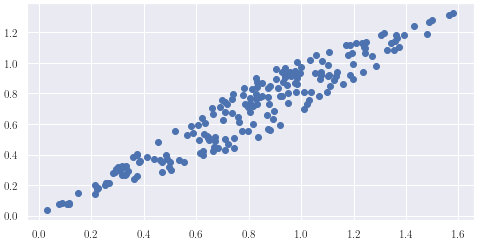

In [289]:
rng = np.random.default_rng()
X = np.dot(rng.random((2, 2)), rng.random((2, 200))).T
plt.scatter(X[:, 0], X[:, 1]);

In [290]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)
print(f'before PCA: {X.shape}')
print(f'after PCA: {X_pca.shape}')

before PCA: (200, 2)
after PCA: (200, 1)


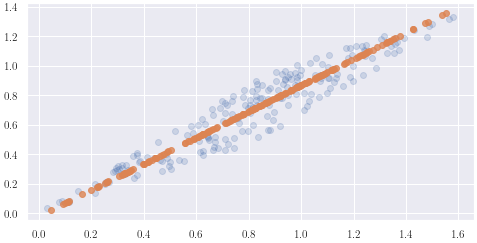

In [291]:
X_ = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_[:, 0], X_[:, 1], alpha=0.8)

In [292]:
X, y = datasets.load_digits(return_X_y=True)
X.shape, y.shape

((1797, 64), (1797,))

In [293]:
pca_2 = PCA(n_components=2)
X_2 = pca_2.fit_transform(X)

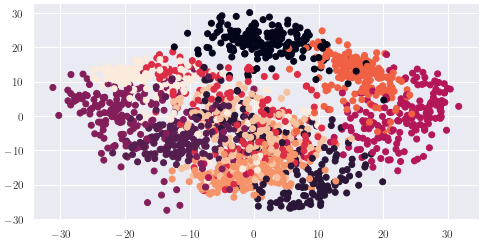

In [313]:
plt.scatter(X_2[:, 0], X_2[:, 1], c=y);

In [295]:
pca_64 = PCA(n_components=64)
X_64 = pca_64.fit_transform(X)

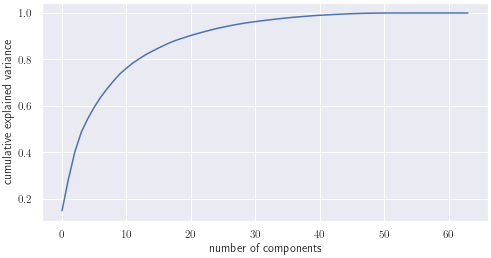

In [296]:
plt.plot(np.cumsum(pca_64.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [297]:
from mpl_toolkits.axes_grid1 import ImageGrid


def plot_digits(data):
    fig = plt.figure(figsize=(12, 5))
    grid = ImageGrid(fig, 111, (4, 10))
    for x, ax in zip(data, grid):
        ax.imshow(x.reshape(8, 8), cmap='binary', interpolation='nearest', clim=(0, 16))
        ax.grid(False)


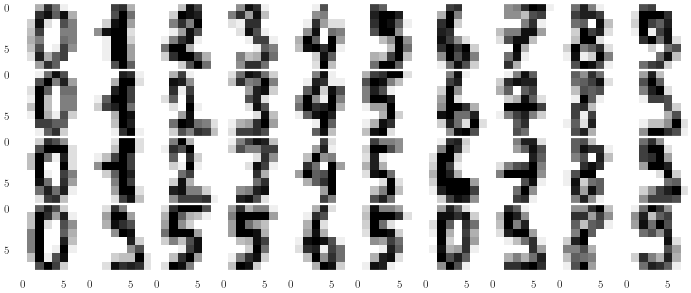

In [298]:
plot_digits(X)

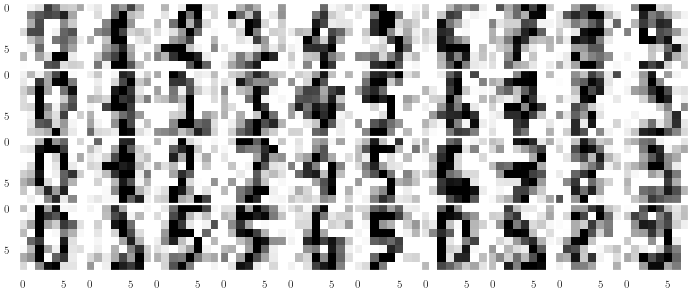

In [299]:
X_ = rng.normal(X, 4)
plot_digits(X_)

In [300]:
pca_20 = PCA(n_components=20)
X_20_ = pca_20.fit_transform(X_)

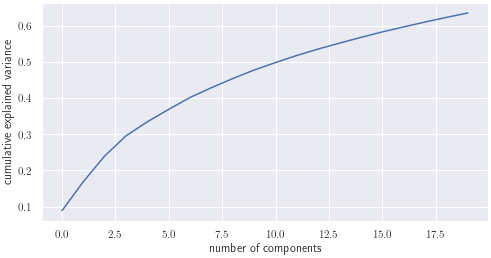

In [301]:
plt.plot(np.cumsum(pca_20.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [302]:
n = 12
np.cumsum(pca_20.explained_variance_ratio_)[n - 1]

0.5178544645081037

In [303]:
pca_12 = PCA(n_components=n)
X_12_ = pca_12.fit_transform(X_)

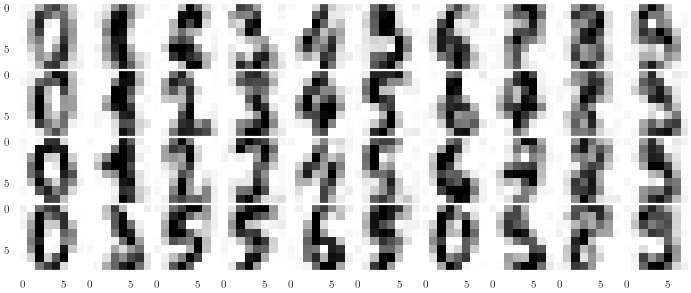

In [304]:
X_pca_ = pca_12.inverse_transform(X_12_)
plot_digits(X_pca_)

In [324]:
param_grid = [{
    'n_components': np.arange(8, 40)
}]

search = GridSearchCV(
    PCA(),
    param_grid,
    cv=ShuffleSplit(n_splits=2, test_size=1, random_state=0),
    verbose=4,
    n_jobs=4,
    return_train_score=True,
)

In [325]:
search.fit(X_, X_);

Fitting 2 folds for each of 32 candidates, totalling 64 fits


In [326]:
pd.DataFrame(search.cv_results_).sort_values('rank_test_score')[['param_n_components', 'mean_train_score']]

,param_n_components,mean_train_score
0,8,-197.004280
1,9,-196.709280
2,10,-196.446487
3,11,-196.253363
4,12,-196.075191
14,22,-195.315349
31,39,-194.961591
5,13,-195.937637
28,36,-194.990650
10,18,-195.504671


best n_components by PCA CV = 20
best n_components by FactorAnalysis CV = 15
best n_components by PCA MLE = 31


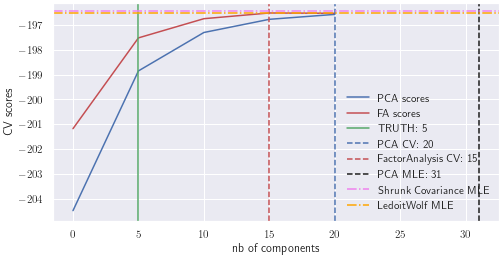

In [308]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# #############################################################################
# Create the data

n_samples, n_features, rank = 500, 25, 5
sigma = 1.0
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))

# #############################################################################
# Fit the models

n_components = np.arange(0, n_features, 5)  # options for n_components


def compute_scores(X):
    pca = PCA(svd_solver="full")
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {"shrinkage": shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


for X in [X_]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver="full", n_components="mle")
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, "b", label="PCA scores")
    plt.plot(n_components, fa_scores, "r", label="FA scores")
    plt.axvline(rank, color="g", label="TRUTH: %d" % rank, linestyle="-")
    plt.axvline(
        n_components_pca,
        color="b",
        label="PCA CV: %d" % n_components_pca,
        linestyle="--",
    )
    plt.axvline(
        n_components_fa,
        color="r",
        label="FactorAnalysis CV: %d" % n_components_fa,
        linestyle="--",
    )
    plt.axvline(
        n_components_pca_mle,
        color="k",
        label="PCA MLE: %d" % n_components_pca_mle,
        linestyle="--",
    )

    # compare with other covariance estimators
    plt.axhline(
        shrunk_cov_score(X),
        color="violet",
        label="Shrunk Covariance MLE",
        linestyle="-.",
    )
    plt.axhline(
        lw_score(X),
        color="orange",
        label="LedoitWolf MLE" % n_components_pca_mle,
        linestyle="-.",
    )

    plt.xlabel("nb of components")
    plt.ylabel("CV scores")
    plt.legend(loc="lower right")

plt.show()

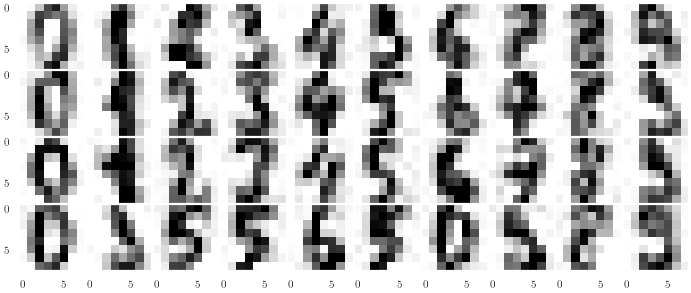

In [309]:
pca_15 = PCA(n_components=15)
X_15_ = pca_15.fit_transform(X_)
X_pca_ = pca_15.inverse_transform(X_15_)
plot_digits(X_pca_)

In [331]:
pipeline = Pipeline([
    ('pca', PCA(n_components=15)), ('clf', SVC(max_iter=1000))
])

param_grid = [{
    'pca': [None, PCA(n_components=15)],
    'clf': [LinearSVC(max_iter=1000), SVC(max_iter=1000)]
}]

search = GridSearchCV(
    pipeline,
    param_grid,
    cv=ShuffleSplit(n_splits=5, test_size=1, random_state=0),
    verbose=4,
    n_jobs=4,
    return_train_score=True,
)

In [334]:
if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        search.fit(X_, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [337]:
pd.DataFrame(search.cv_results_).sort_values('rank_test_score')[[
    'mean_fit_time',
    'mean_score_time',
    'param_clf',
    'param_pca',
    'mean_train_score',
]]

,mean_fit_time,mean_score_time,param_clf,param_pca,mean_train_score
0,0.518440,0.000200,LinearSVC(),None,0.907127
2,0.130562,0.000400,SVC(max_iter=1000),None,0.992205
3,0.096154,0.000203,SVC(max_iter=1000),PCA(n_components=15),0.978731
1,0.359446,0.000401,LinearSVC(),PCA(n_components=15),0.834521
